In [1]:
import pandas as pd
import numpy as np
import os
import sys
import json
import matplotlib.pyplot as plt
import matplotlib.patches as pch
import cv2
from tqdm import tqdm

import os
import json
from PIL import Image
from typing import Dict

import random
import cv2
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
# from rapidfuzz.distance.Levenshtein import distance as levenshtein

**Mounted Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
link_data = "/content/drive/MyDrive/miniProject/benetech-making-graphs-accessible.zip"

In [ ]:
!unzip /content/drive/MyDrive/miniProject/benetech-making-graphs-accessible.zip -d dataset

#Util Function

In [ ]:
class CFG:
    train_img_path: str = "/content/dataset/train/images"
    train_ann_path: str = "/content/dataset/train/annotations"
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def get_annotations():
    annotations_path = "/content/dataset/train/annotations"
    
    annotations = []
    for annotation_path in os.listdir(CFG.train_ann_path):
        with open(f"{CFG.train_ann_path}/{annotation_path}") as annotation_f:
            annotations.append(json.load(annotation_f))
    return annotations

def get_chart_type_counts(annotations):
    chart_type_counts = {
        "dot": 0,
        "line": 0,
        "scatter": 0,
        "vertical_bar": 0,
        "horizontal_bar": 0
    }
    
    for annotation in annotations:
        chart_type_counts[annotation["chart-type"]] += 1
            
    return chart_type_counts

def load_annotation(name: str) -> Dict:
    with open(f"{CFG.train_ann_path}/{name}.json") as annotation_f:
        ann_example = json.load(annotation_f)
    return ann_example

def get_coords(polygon, img_height):
    xs = [
        polygon["x0"], 
        polygon["x1"], 
        polygon["x2"], 
        polygon["x3"], 
        polygon["x0"]
    ]
    
    ys = [
        -polygon["y0"] + img_height, 
        -polygon["y1"] + img_height, 
        -polygon["y2"] + img_height, 
        -polygon["y3"] + img_height, 
        -polygon["y0"] + img_height
    ]
    
    return xs, ys

def add_line_breaks(text: str, break_num: int = 7) -> str:
    words = text.split()
    new_text = ""
    for i, word in enumerate(words, start=1):
        new_text += word
        if i % break_num == 0:
            new_text += "<br>"
        else:
            new_text += " "
    return new_text

def get_tick_value(name, data_series):
    for el in data_series:
        if el["x"] == name:
            return el["y"]
        elif el["y"] == name:
            return el["x"]

def plot_annotated_image(name: str, scale_factor: int = 1.0) -> None:
    img_example = Image.open(f"{CFG.train_img_path}/{name}.jpg")
    ann_example = load_annotation(name)
    
    # create figure
    fig = go.Figure()

    # constants
    img_width = img_example.size[0]
    img_height = img_example.size[1]
    

    # add invisible scatter trace
    fig.add_trace(
        go.Scatter(
            x=[0, img_width],
            y=[0, img_height],
            mode="markers",
            marker_opacity=0
        )
    )

    # configure axes
    fig.update_xaxes(
        visible=False,
        range=[0, img_width]
    )

    fig.update_yaxes(
        visible=False,
        range=[0, img_height],
        # the scaleanchor attribute ensures that the aspect ratio stays constant
        scaleanchor="x"
    )

    # add image
    fig.add_layout_image(dict(
        x=0,
        sizex=img_width,
        y=img_height,
        sizey=img_height,
        xref="x", yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=img_example
    ))
    
    # add bounding box
    fig.add_shape(
        type="rect",
        x0=ann_example["plot-bb"]["x0"], 
        y0=-ann_example["plot-bb"]["y0"] + img_height, 
        x1=ann_example["plot-bb"]["x0"] + ann_example["plot-bb"]["width"], 
        y1=-(ann_example["plot-bb"]["y0"] + ann_example["plot-bb"]["height"]) + img_height,
        line=dict(color="RoyalBlue"),
    )
    
    # add polygons
    for text in ann_example["text"]:
        name = text["text"]
        
        if text["role"] == "tick_label":
            tick_value = get_tick_value(name, ann_example["data-series"])
            if tick_value:
                name = f'Text: {name}<br>Value: {tick_value}'
        
        xs, ys = get_coords(text["polygon"], img_height)
        fig.add_trace(go.Scatter(
            x=xs, y=ys, fill="toself",
            name=add_line_breaks(name),
            hovertemplate="%{name}",
            mode='lines'
        ))
    
    # add x-axis dots
    xs = [dot["tick_pt"]["x"] for dot in ann_example["axes"]["x-axis"]["ticks"]]
    ys = [-dot["tick_pt"]["y"] + img_height for dot in ann_example["axes"]["x-axis"]["ticks"]]
    fig.add_trace(go.Scatter(
        x=xs, y=ys, mode='markers',
        name="x-axis"
    ))
    
    # add y-axis dots
    xs = [dot["tick_pt"]["x"] for dot in ann_example["axes"]["y-axis"]["ticks"]]
    ys = [-dot["tick_pt"]["y"] + img_height for dot in ann_example["axes"]["y-axis"]["ticks"]]
    fig.add_trace(go.Scatter(
        x=xs, y=ys, mode='markers',
        name="y-axis"
    ))

    # configure other layout
    fig.update_layout(
        width=img_width * scale_factor,
        height=img_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
        showlegend=False
    )

    # disable the autosize on double click because it adds unwanted margins around the image
    # and finally show figure
    fig.show(config={'doubleClick': 'reset'})

#Processing

**Processing annotation**

In [ ]:
def convert_annot2df(path):
    res = []
    col_name = ['name', 'source', 'chart-type', 'plot-bb', 'text', 'x_axis', 'y_axis', 'data_series_x', 'data_series_y']
    for i in tqdm(os.listdir(path)):
        try:
            tmp_name = i[:-5]
            tmp_data = [tmp_name]
            tmp_json_file_path = os.path.join(path, i)
            with open(tmp_json_file_path, 'r') as tmp_file:
                tmp_json_data = json.load(tmp_file)
            
            tmp_data.append(tmp_json_data['source']) # generated / extracted
            tmp_data.append(tmp_json_data['chart-type']) # dot, horizontal_bar, vertical_bar, line, scatter.
            tmp_data.append(','.join(map(str, [tmp_json_data['plot-bb']['height'], tmp_json_data['plot-bb']['width'], 
                                              tmp_json_data['plot-bb']['x0'], tmp_json_data['plot-bb']['y0']])))
            
            # text
            tmp_data.append(tmp_json_data['text'])
            # axes
            tmp_data.append(tmp_json_data['axes']['x-axis'])
            tmp_data.append(tmp_json_data['axes']['y-axis'])
            # data_series_x
            tmp_data_series_x = []
            # data_series_y
            tmp_data_series_y = []
            for ds in tmp_json_data['data-series']:
                tmp_data_series_x.append(str(ds['x']))
                tmp_data_series_y.append(str(ds['y']))
            tmp_data.append(';'.join(tmp_data_series_x))
            tmp_data.append(';'.join(tmp_data_series_y))
            
            res.append(tmp_data)
        except:
          continue
    
    return pd.DataFrame(res, columns=col_name)
        

In [ ]:
annotation_df = convert_annot2df('/content/dataset/train/annotations')

100%|██████████| 60578/60578 [00:30<00:00, 1994.37it/s]


In [ ]:
annotation_df.head()

,name,source,chart-type,plot-bb,text,x_axis,y_axis,data_series_x,data_series_y
0,e31c472beaba,generated,vertical_bar,"107,426,59,74","[{'id': 0, 'polygon': {'x0': 66, 'x1': 428, 'x...","{'ticks': [{'id': 12, 'tick_pt': {'x': 81, 'y'...","{'ticks': [{'id': 3, 'tick_pt': {'x': 59, 'y':...",New Caledonia;New Zealand;Nicaragua;Niger;Nige...,101.70786678669101;102.60674296002087;102.0074...
1,5d051417dcbc,generated,scatter,"203,410,71,43","[{'id': 0, 'polygon': {'x0': 123, 'x1': 371, '...","{'ticks': [{'id': 3, 'tick_pt': {'x': 71, 'y':...","{'ticks': [{'id': 12, 'tick_pt': {'x': 71, 'y'...",1985.0764725024405;1991.9101854864953;1993.797...,66.82878738087413;79.97371015445285;78.9221163...
2,6aee37df5a46,generated,scatter,"206,406,59,23","[{'id': 0, 'polygon': {'x0': 97, 'x1': 408, 'x...","{'ticks': [{'id': 9, 'tick_pt': {'x': 59, 'y':...","{'ticks': [{'id': 3, 'tick_pt': {'x': 59, 'y':...",0.9901510177281674;1.963230466185161;2.9875246...,86.10369651379125;87.5596538057107;95.81007845...
3,cdae24bee611,generated,vertical_bar,"188,393,76,38","[{'id': 0, 'polygon': {'x0': 76, 'x1': 465, 'x...","{'ticks': [{'id': 10, 'tick_pt': {'x': 91, 'y'...","{'ticks': [{'id': 3, 'tick_pt': {'x': 76, 'y':...",1992;1994;1996;1998;2000;2002;2004;2006;2008;2...,52.34517586604058;44.690351732081155;49.155665...
4,105304357b9a,generated,vertical_bar,"157,398,65,42","[{'id': 0, 'polygon': {'x0': 55, 'x1': 418, 'x...","{'ticks': [{'id': 3, 'tick_pt': {'x': 85, 'y':...","{'ticks': [{'id': 13, 'tick_pt': {'x': 65, 'y'...",United Kingdom;United States;United States Vir...,113060758.25558984;179758399.36290917;12640028...


**Remove horizontal bar**

In [ ]:
annotation_df.groupby(['source', 'chart-type'])['chart-type'].count()

source     chart-type    
extracted  horizontal_bar       73
           line                423
           scatter             165
           vertical_bar        457
generated  dot                5131
           line              24519
           scatter           11078
           vertical_bar      18731
Name: chart-type, dtype: int64

In [ ]:
annotation_df = annotation_df.drop(annotation_df[annotation_df['chart-type'] == 'horizontal_bar'].index)

In [ ]:
annotation_df.groupby(['source', 'chart-type'])['chart-type'].count()

source     chart-type  
extracted  line              423
           scatter           165
           vertical_bar      457
generated  dot              5131
           line            24519
           scatter         11078
           vertical_bar    18731
Name: chart-type, dtype: int64

**Visualization**


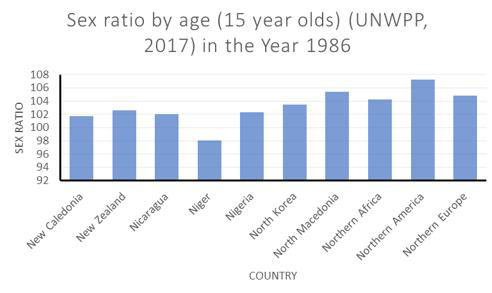

In [ ]:
plot_annotated_image('e31c472beaba', scale_factor=1.5)

**Donut experiment**